<a href="https://colab.research.google.com/github/project4sharing/exp_credit_card_fraud/blob/initial/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High Level Exercise Goal
This project is a Credit Card Fraud experiment leveraging data from Kaggle .  

Although different types of electronic payment methods have evolved over time, credit card payment method still takes on a significant portion of overall payment method.  Because of this, credit card fraud detection is still very much relevant to payment processor aand fraudulent charge could be stopped or confirmed by the card holder (transaction held until card holder confirms purchase).  This is a very common scenario that a lot of us may have experienced and that's also the reason why I choose this data source for my learning journey.

The objective of this ML exercise is to:  
1. Train a surpervised learning model (learning from labelled data) for #2
2. Determine if a credit card transaction is "potentially" fradulent
3.  Exercise "muscle memory" of common Machine Learning (ML) best practice:
*   Data wangling & cleaning
*   Exploratory data analysis (EDA)




# Data Sources
Credit Card Fraud data source hosted in Kaggle by Dhanush NaraYanan R.

https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data

This data source is licensed under "CC0: Publich Domain".

Data source containes 1MM samples of 8 features:
1. distance_from_home - numberic - Distance from credit card registration address
2. distance_from_last_transaction - numeric - Distance of the current transation from the previous transaction on the same credit card
3. ratio_to_median_purchase_price - numeric - Ratio of current charge to median purchase price
4. repeat_retailer - categorical - current charge made to frequent store / retailer
5. used_chip - categorical - IC chip used to authorize charge
6. used_pin_number - categorical - PIN used to authorize charge
7. online_order - categorical - current charge made for online purchase
8. fraud - categorical - prediction of whether charge may be fraudulent - this is the target variable that we would like to predict

At a first glance, the initial intuition is feature #1, #2, #5, #6 are "card present" type of purchases, ie, card holder makes purchase in person.

Note: To make this notebook more self-contained (and tried to avoid storing my Kaggle API key for download in the notebook -- a bad practice), I copied the data to my Google drive.

# Acquire Additional Packages
Acquire additional Python packages that may not be readily available in the Jupyter notebook environment (in this case Google Colab)

Packages list:


*   gdown - Used to download credit card transacation data stored in Google drive (card-transdata.csv)



In [1]:
# Acquire prerequisite packages
!pip install gdown

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import gdown

In [3]:
gdown.download('https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo', 'card_transdata.csv')

Downloading...
From: https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo
To: /content/card_transdata.csv
100%|██████████| 76.3M/76.3M [00:02<00:00, 31.8MB/s]


'card_transdata.csv'

In [4]:
df_credit_card_fraud_org = pd.read_csv('./card_transdata.csv', sep=',', header=0, index_col=False, engine='python')

In [5]:
df_credit_card_fraud_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [6]:
df_credit_card_fraud_org.describe(include='all')

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


# Basic Data Understanding

*   From DF.info():
  *   the data set shape is a 100k x 8 tabular data, all features are of numeric type and there seems to be no missing data
  *   most of the features seem to be appropriate as numeric data
  *   repeat_retailer, used_chip, used_pin_number, online_order may be categorical data, but will validate data at a later time
  *   label "fraud" is the target prediction variable




*   Identify data types of each feature
*   Determine if categorical data needs to be converted (Pandas' get_dummies())
*   Identify missing values
*   Identify



# **EDA**

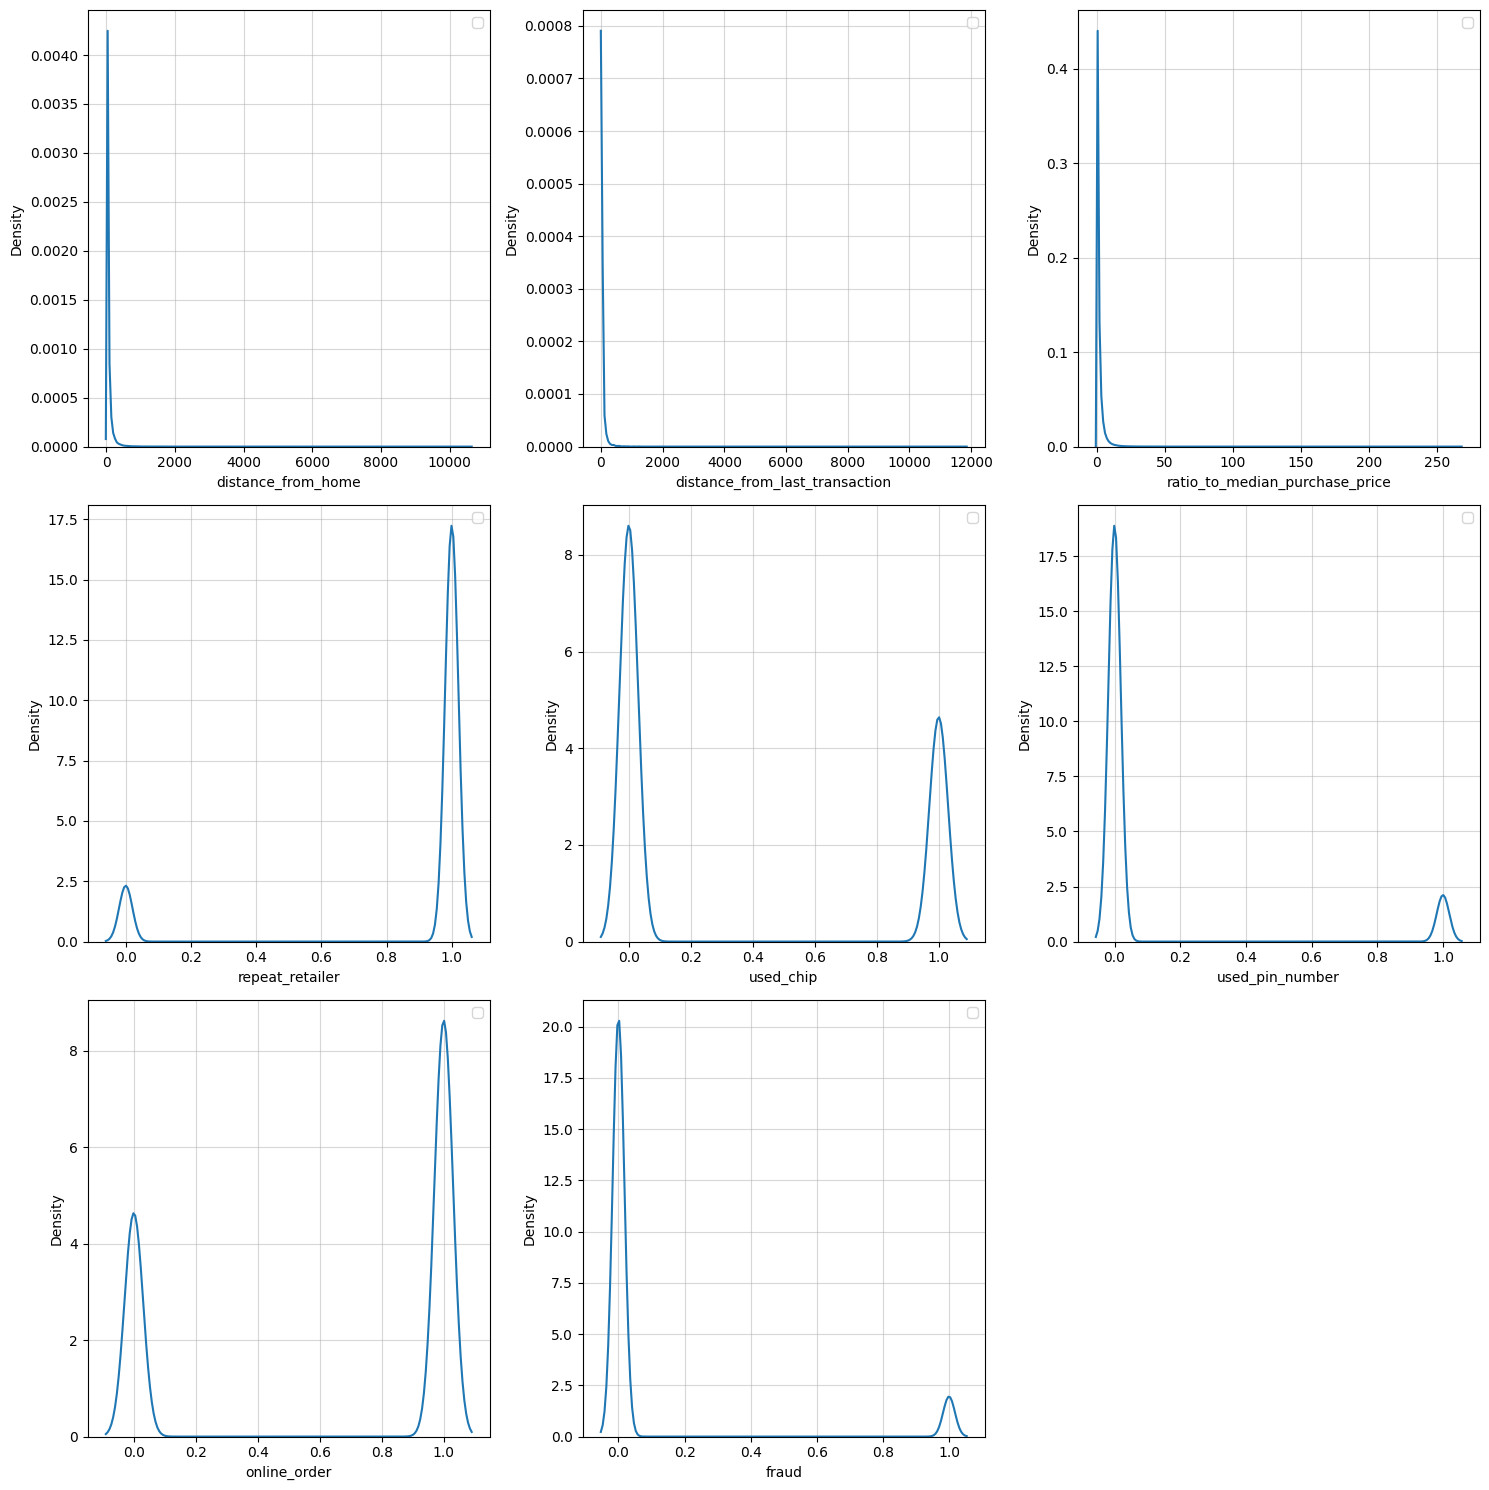

In [9]:
fig = plt.figure(figsize=(15, 15))
rows, cols = 3, 3
for i, col_name in enumerate(df_credit_card_fraud_org.loc[:, 'distance_from_home' : 'fraud'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = df_credit_card_fraud_org)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()